CNN

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
img = x_test[0]
img = np.expand_dims(img, axis=-1)  # Add channel dimension (1 channel, grayscale)

# Resize image to (256, 256) to match the model input
img_resized = tf.image.resize(img, (256, 256))

# Normalize the image to [0, 1] range
img_resized = img_resized / 255.0

# Add batch dimension (model expects a batch of images)
img_resized = np.expand_dims(img_resized, axis=0)

In [14]:
# Define your model using the functional API to avoid the input layer warning
input_layer = tf.keras.layers.Input(shape=(256, 256, 1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)  # Adjust for 10 classes (for MNIST)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Build the model (this ensures the model is initialized)
model.build(input_shape=(None, 256, 256, 1))

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
def visualize_model_layers(model, img_array):
    # Create a model that outputs the activations of all layers
    layer_outputs = [layer.output for layer in model.layers]  # List of all layer outputs
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

    # Get the activations of the image
    activations = activation_model.predict(img_array)

    # Plot the outputs of each layer
    for i, activation in enumerate(activations):
        print(f"Layer {i+1}: {model.layers[i].name} - Shape: {activation.shape}")

        # If the layer output has 3 dimensions (height, width, channels), visualize the feature maps
        if len(activation.shape) == 4:  # Conv2D or MaxPooling2D
            num_filters = activation.shape[-1]
            size = activation.shape[1]

            # Ensure at least one row is created for small number of filters
            num_rows = max(1, num_filters // 8)
            num_cols = min(num_filters, 8)

            # Create a grid of subplots to show the feature maps
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

            # Ensure axes is iterable even if it's a single Axes object
            if num_rows == 1 and num_cols == 1:
                axes = [axes]
            else:
                axes = axes.ravel()  # Flatten the axes array

            for j in range(num_filters):
                ax = axes[j]
                # Display in grayscale by setting cmap to 'gray'
                ax.imshow(activation[0, :, :, j], cmap='gray')
                ax.axis('off')

            plt.tight_layout()
            plt.show()
        else:
            # If it's a 1D output (like Dense layers or GlobalAveragePooling2D), plot it as a vector
            plt.figure(figsize=(10, 2))
            plt.imshow(activation[0].reshape(1, -1), cmap='gray', aspect='auto')
            plt.colorbar()
            plt.title(f"Layer {i+1}: {model.layers[i].name} - Shape: {activation.shape}")
            plt.axis('off')
            plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Layer 1: input_layer - Shape: (1, 256, 256, 1)


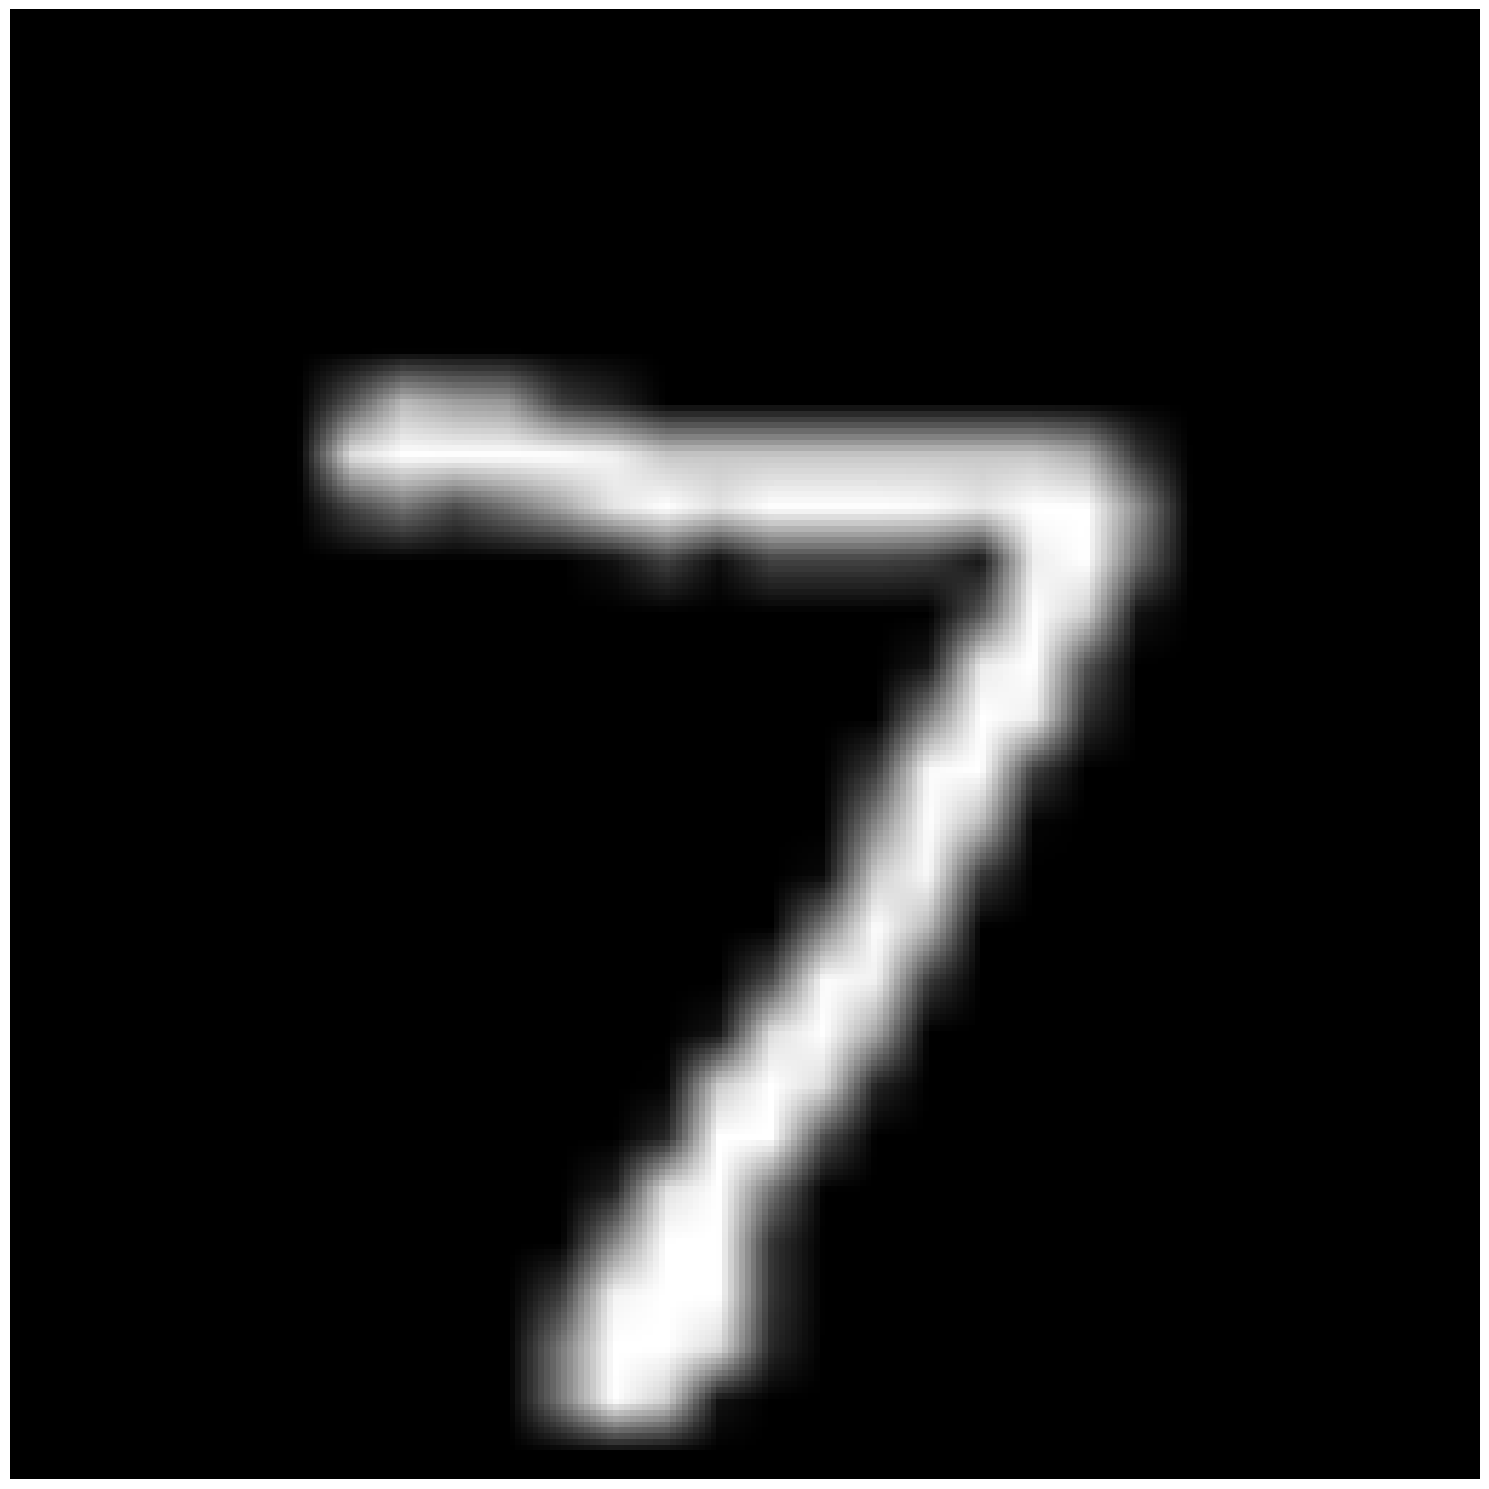

Layer 2: rescaling - Shape: (1, 256, 256, 1)


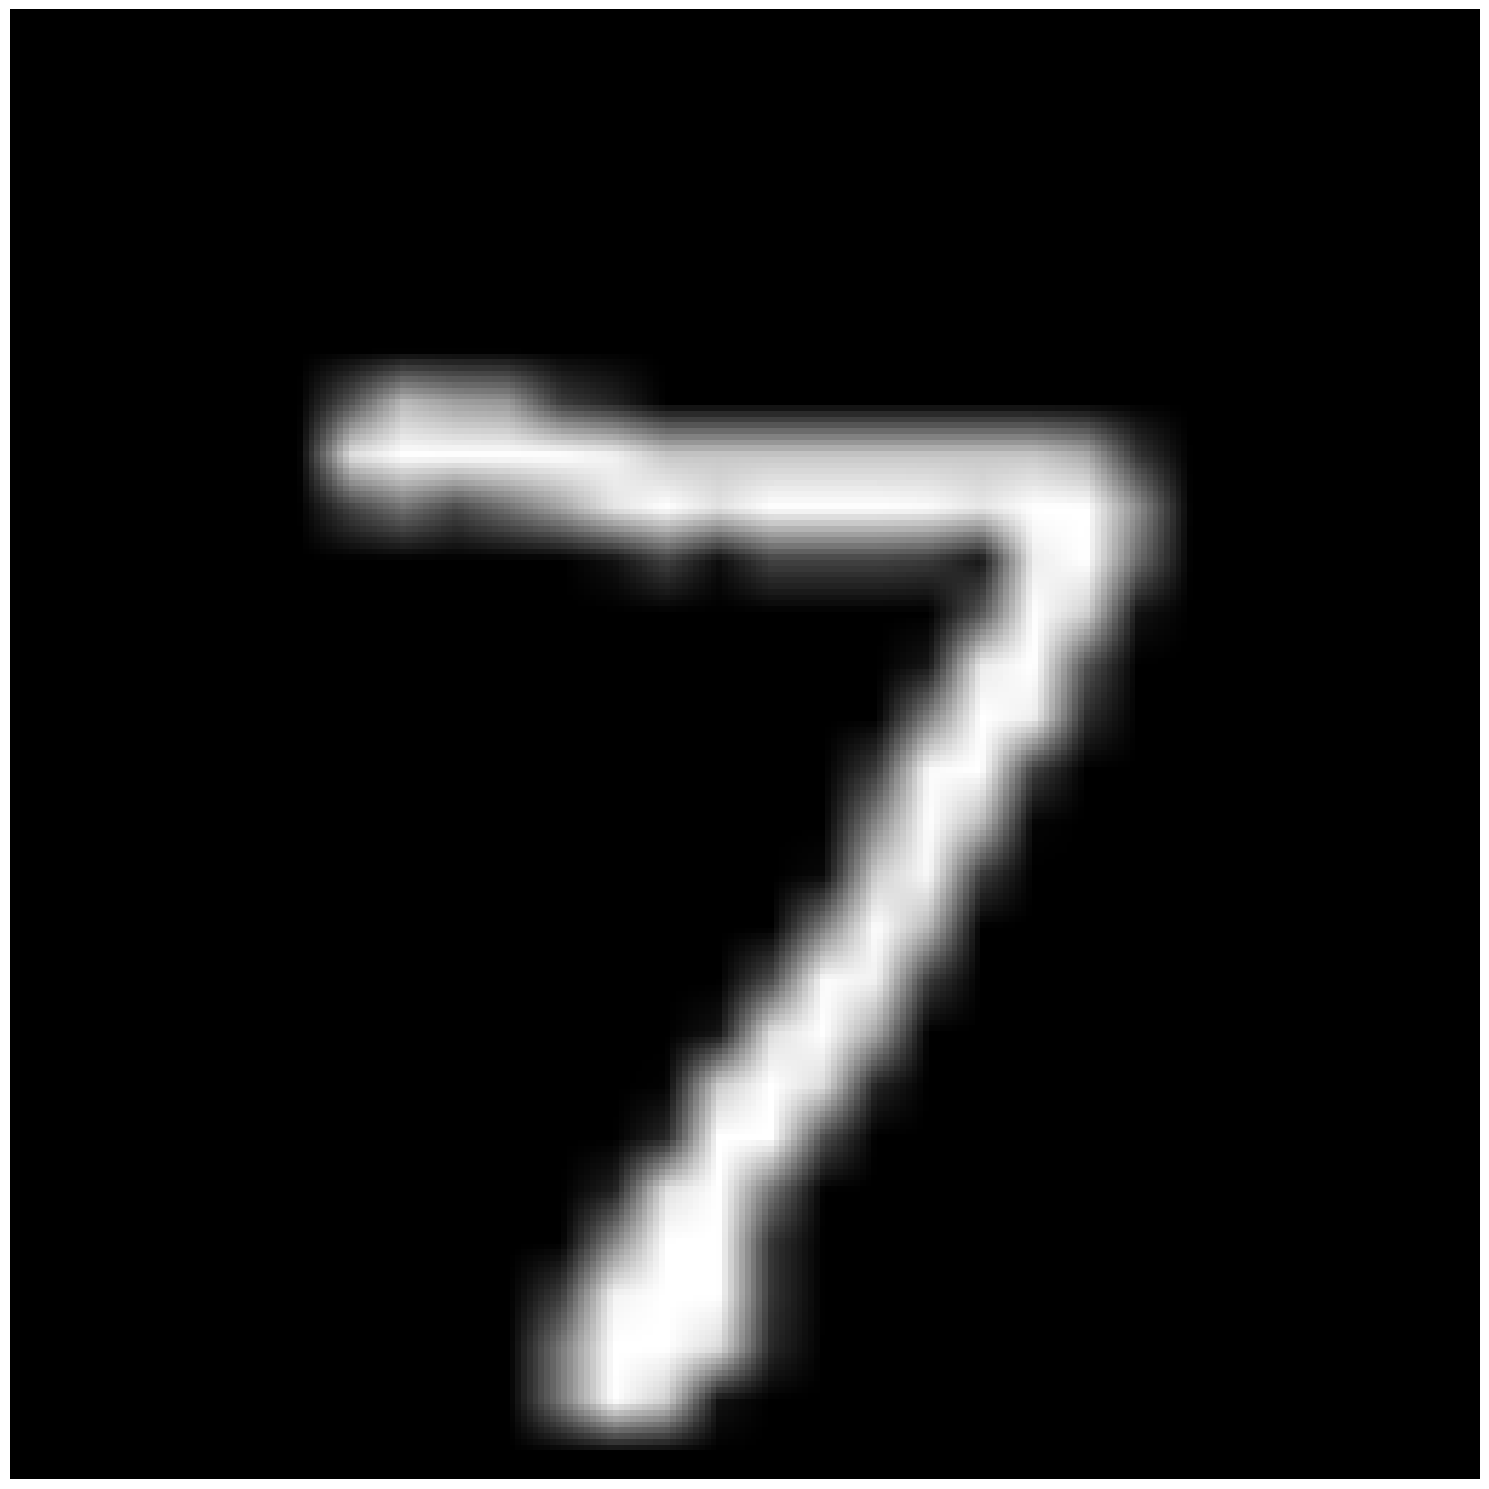

Layer 3: conv2d - Shape: (1, 254, 254, 32)


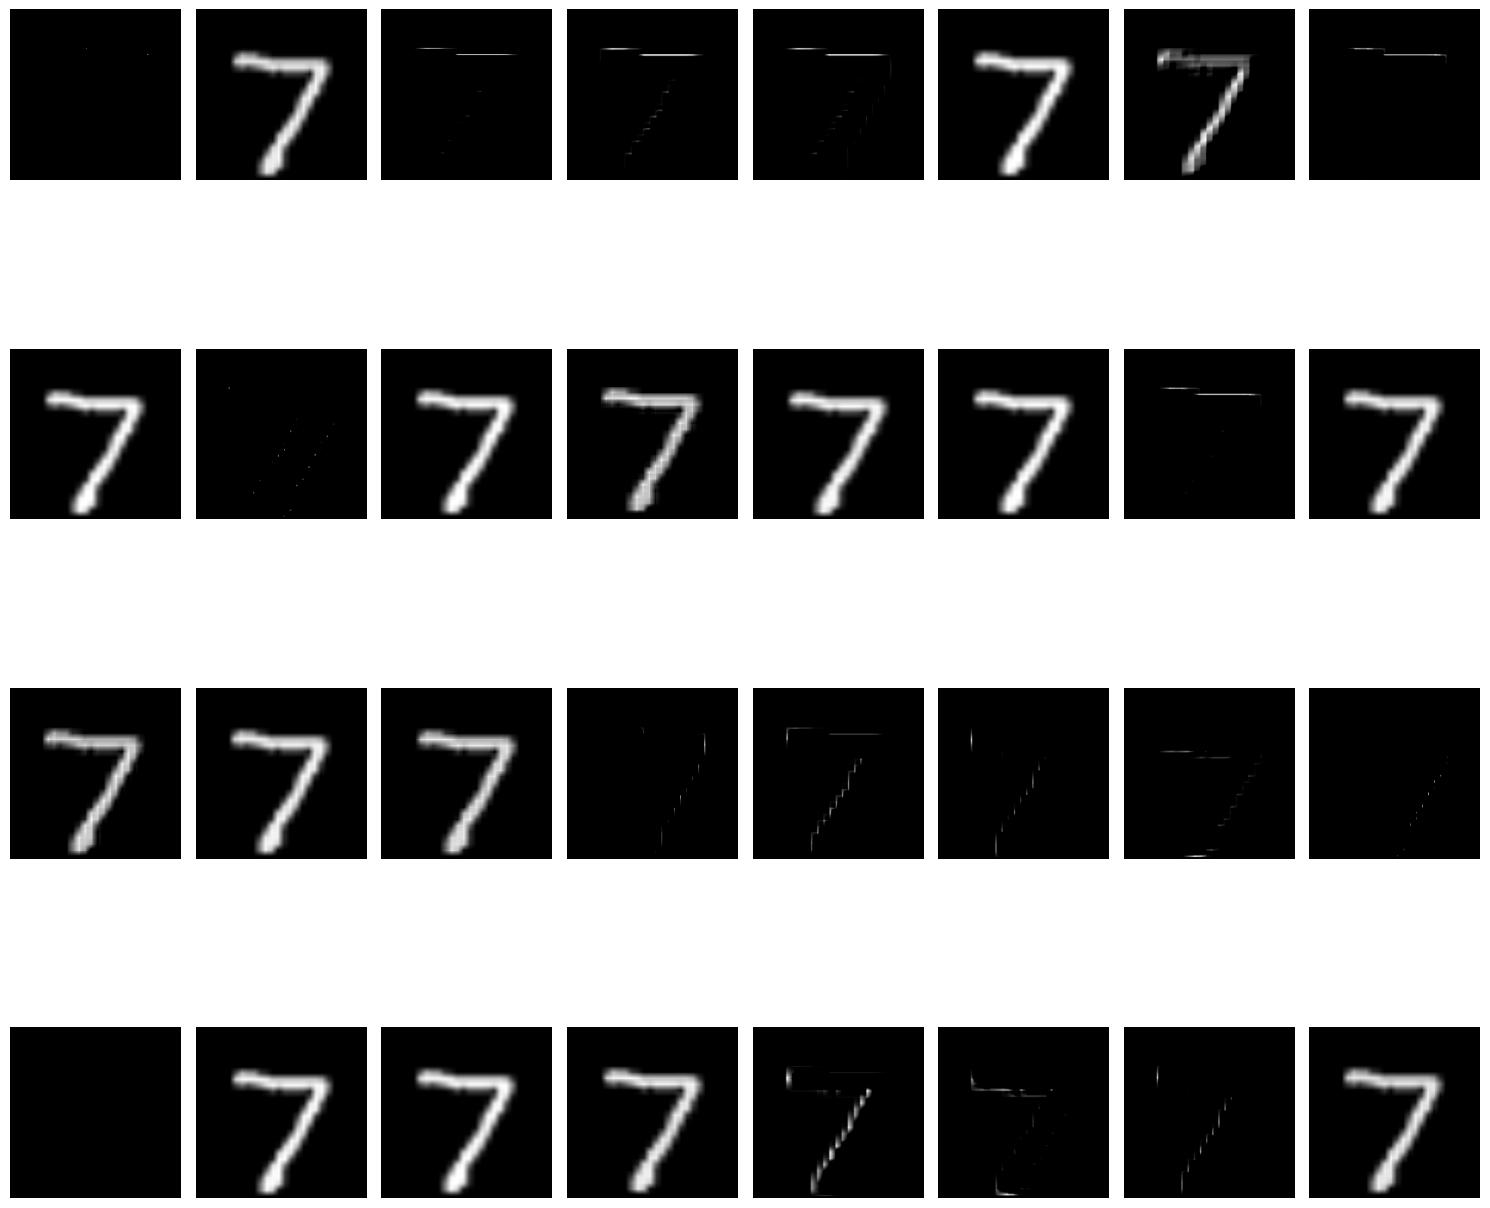

Layer 4: max_pooling2d - Shape: (1, 127, 127, 32)


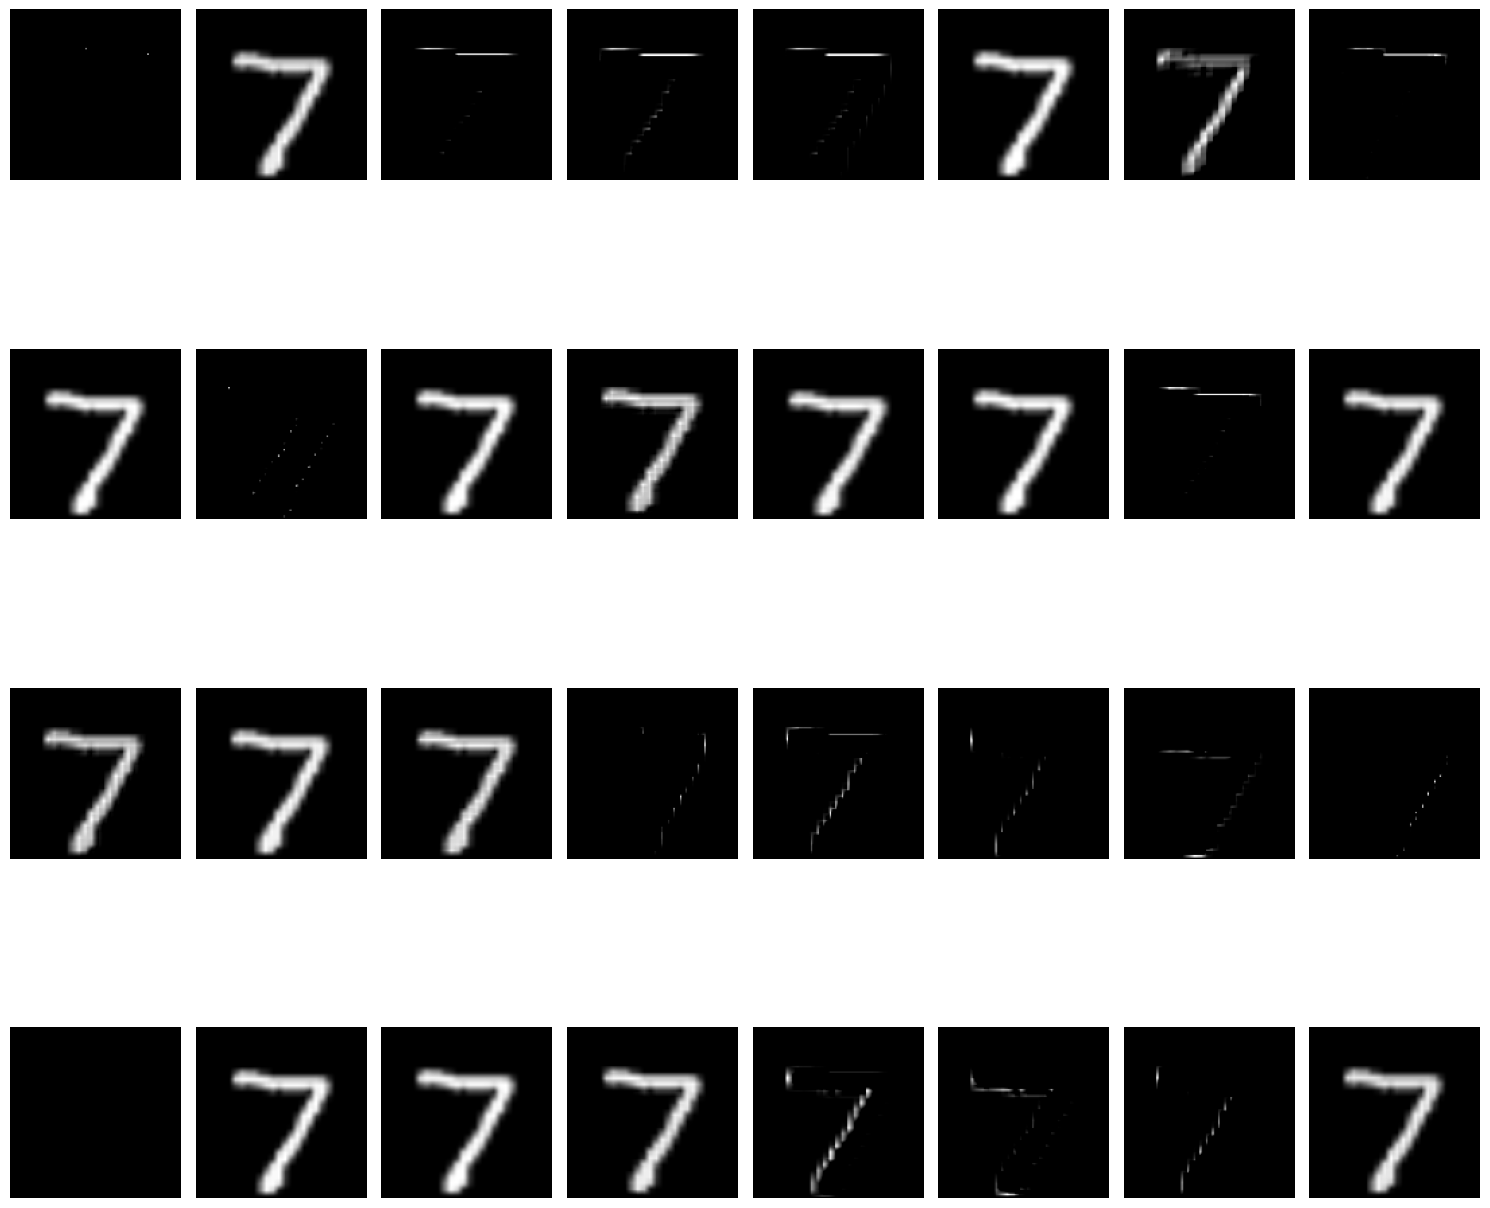

Layer 5: conv2d_1 - Shape: (1, 125, 125, 64)


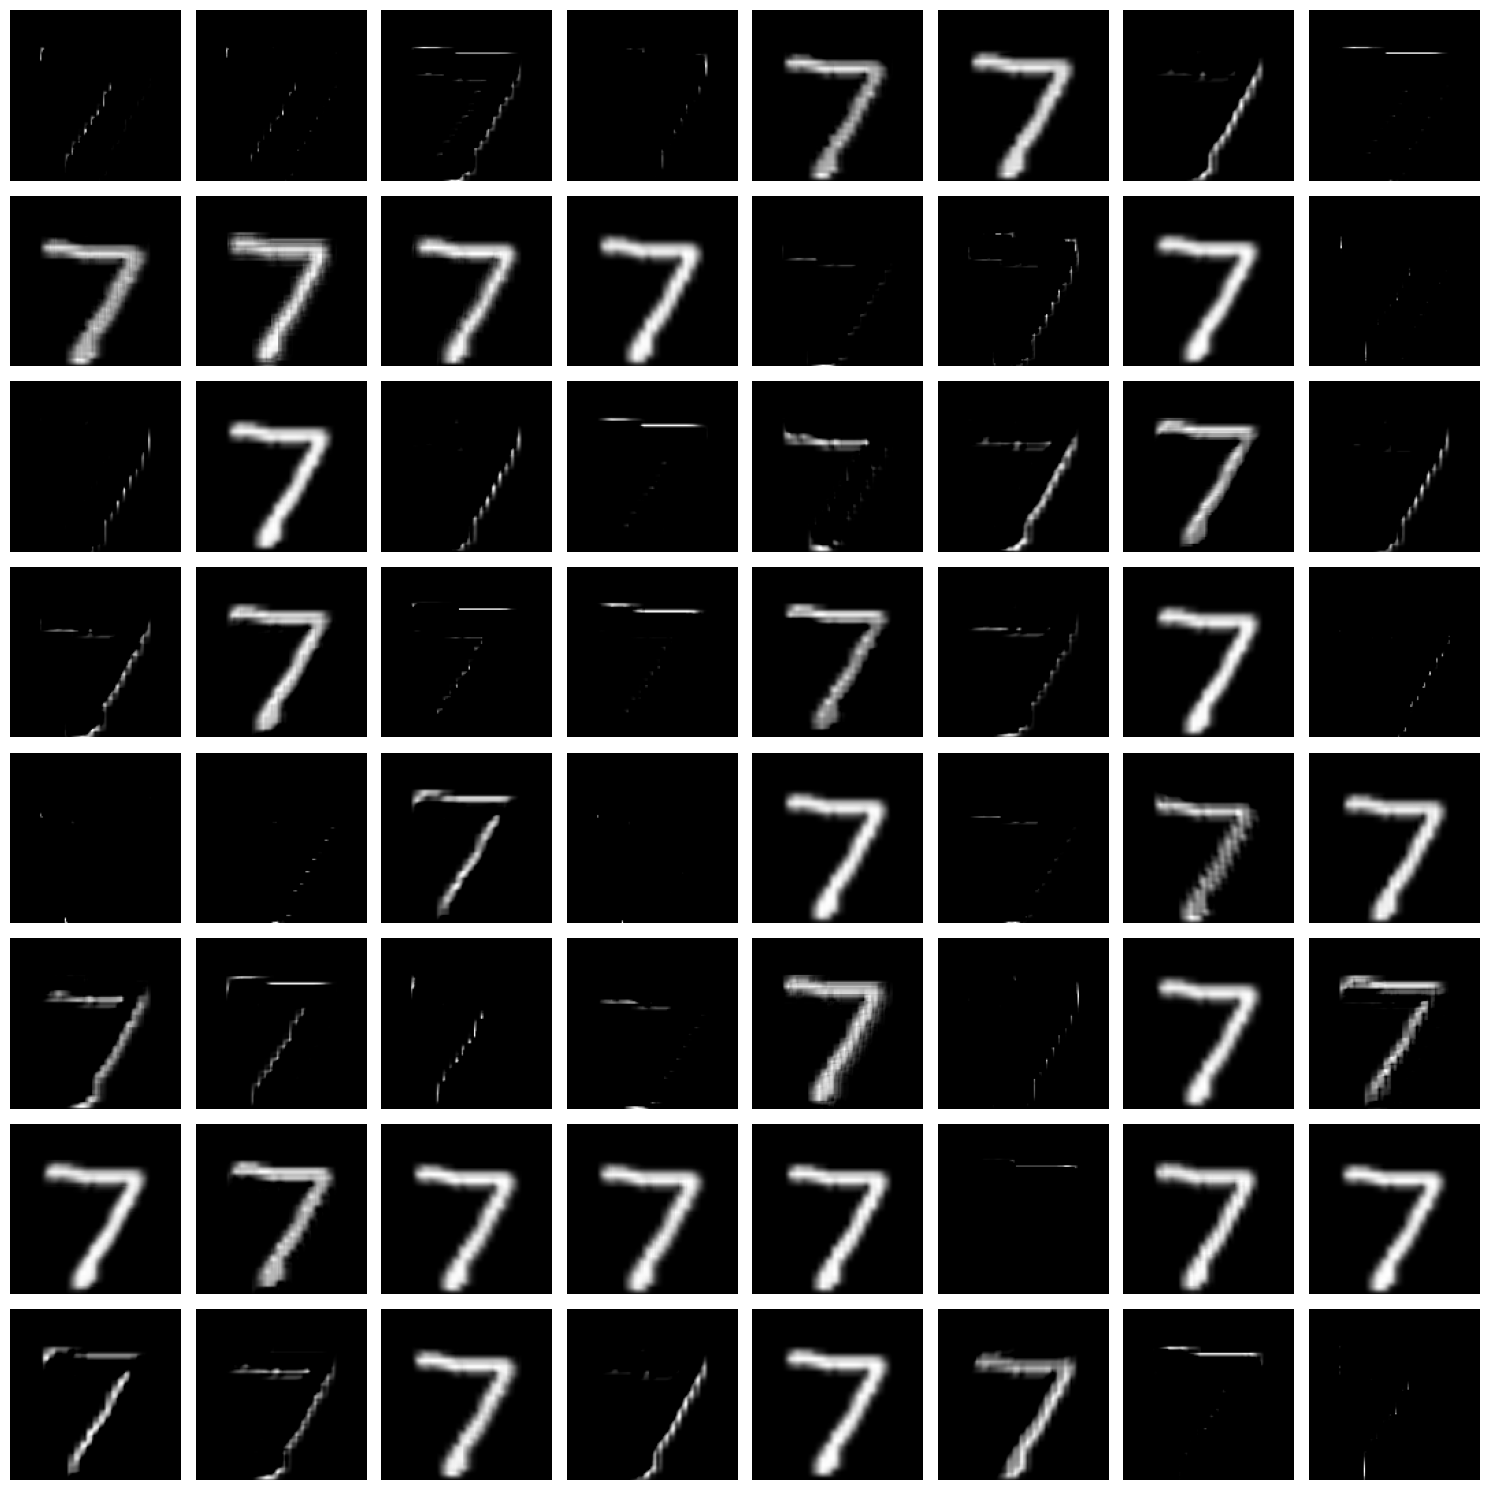

Layer 6: max_pooling2d_1 - Shape: (1, 62, 62, 64)


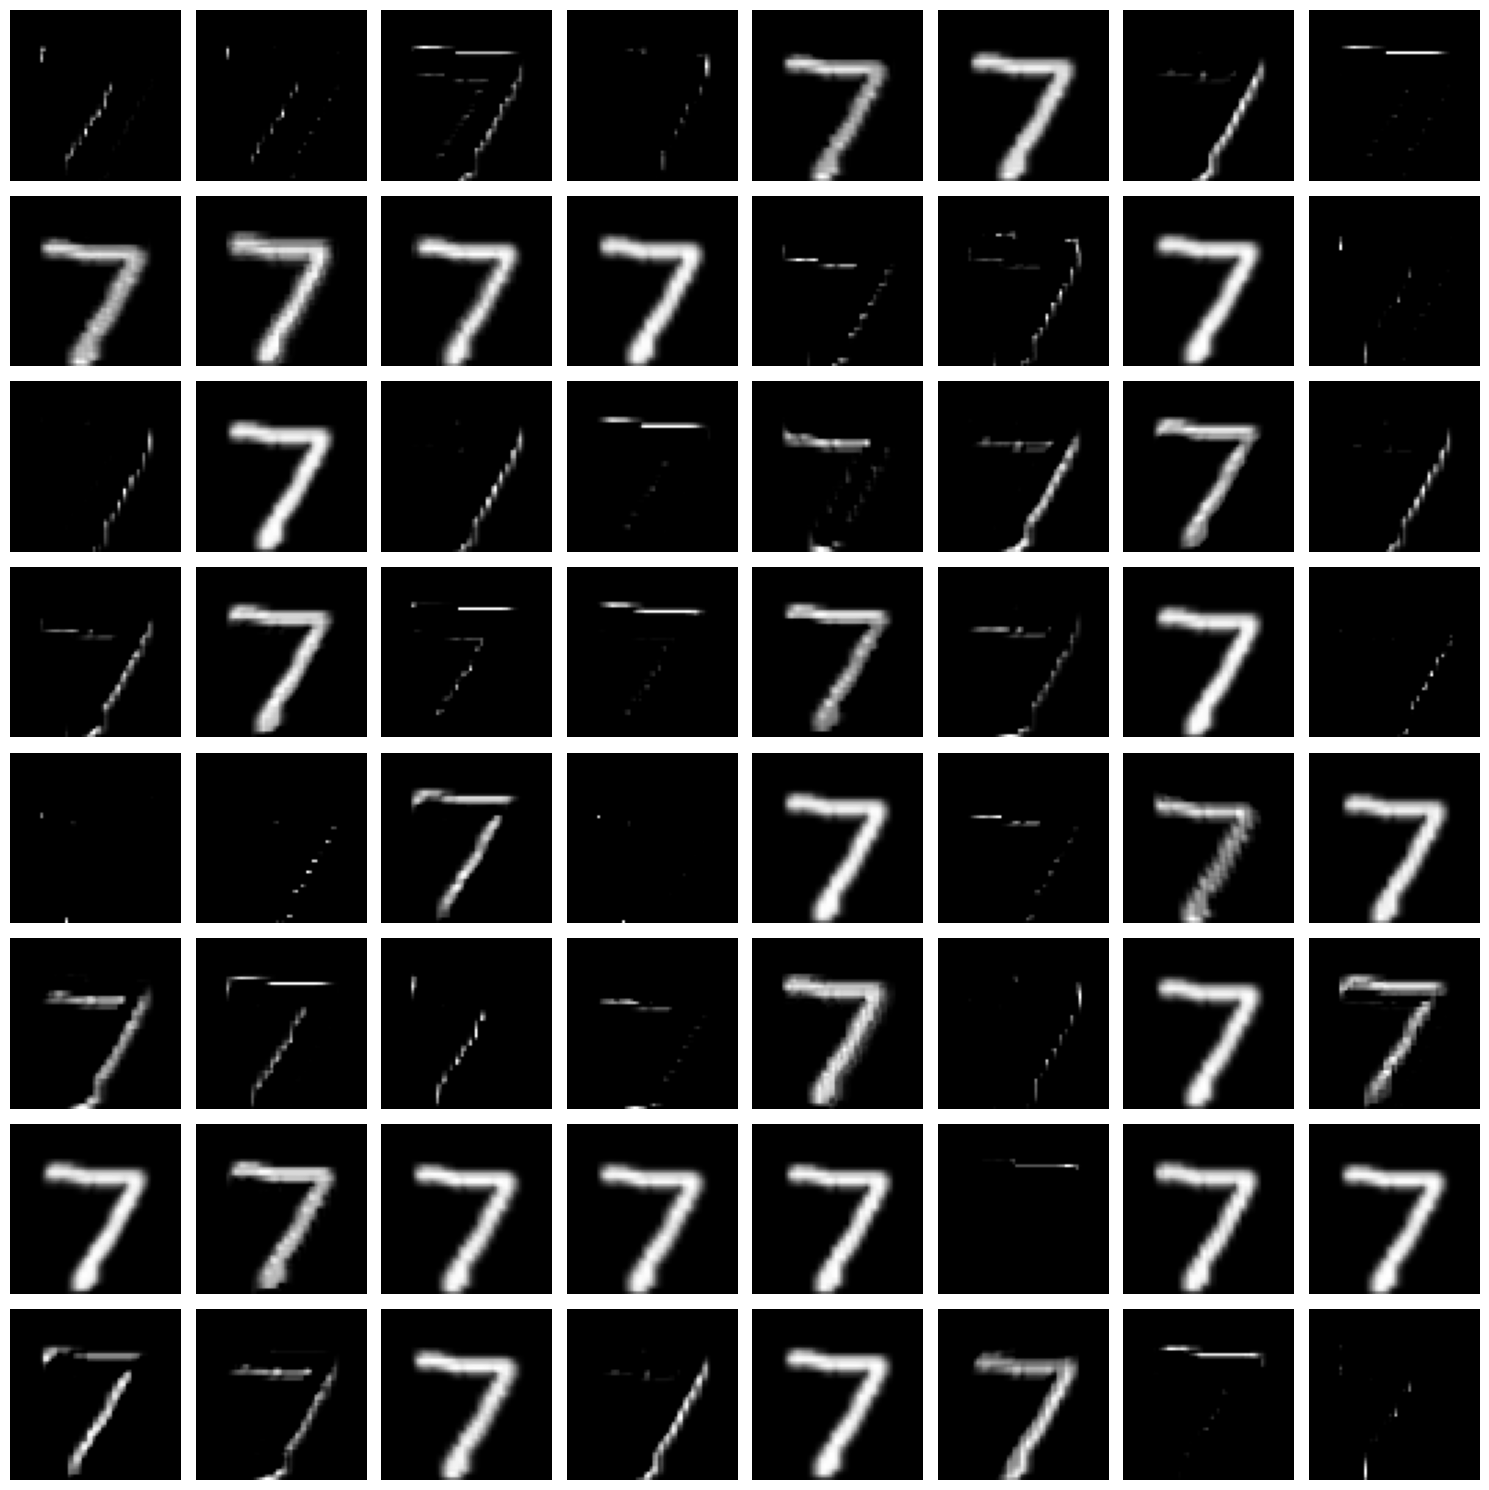

Layer 7: conv2d_2 - Shape: (1, 60, 60, 128)


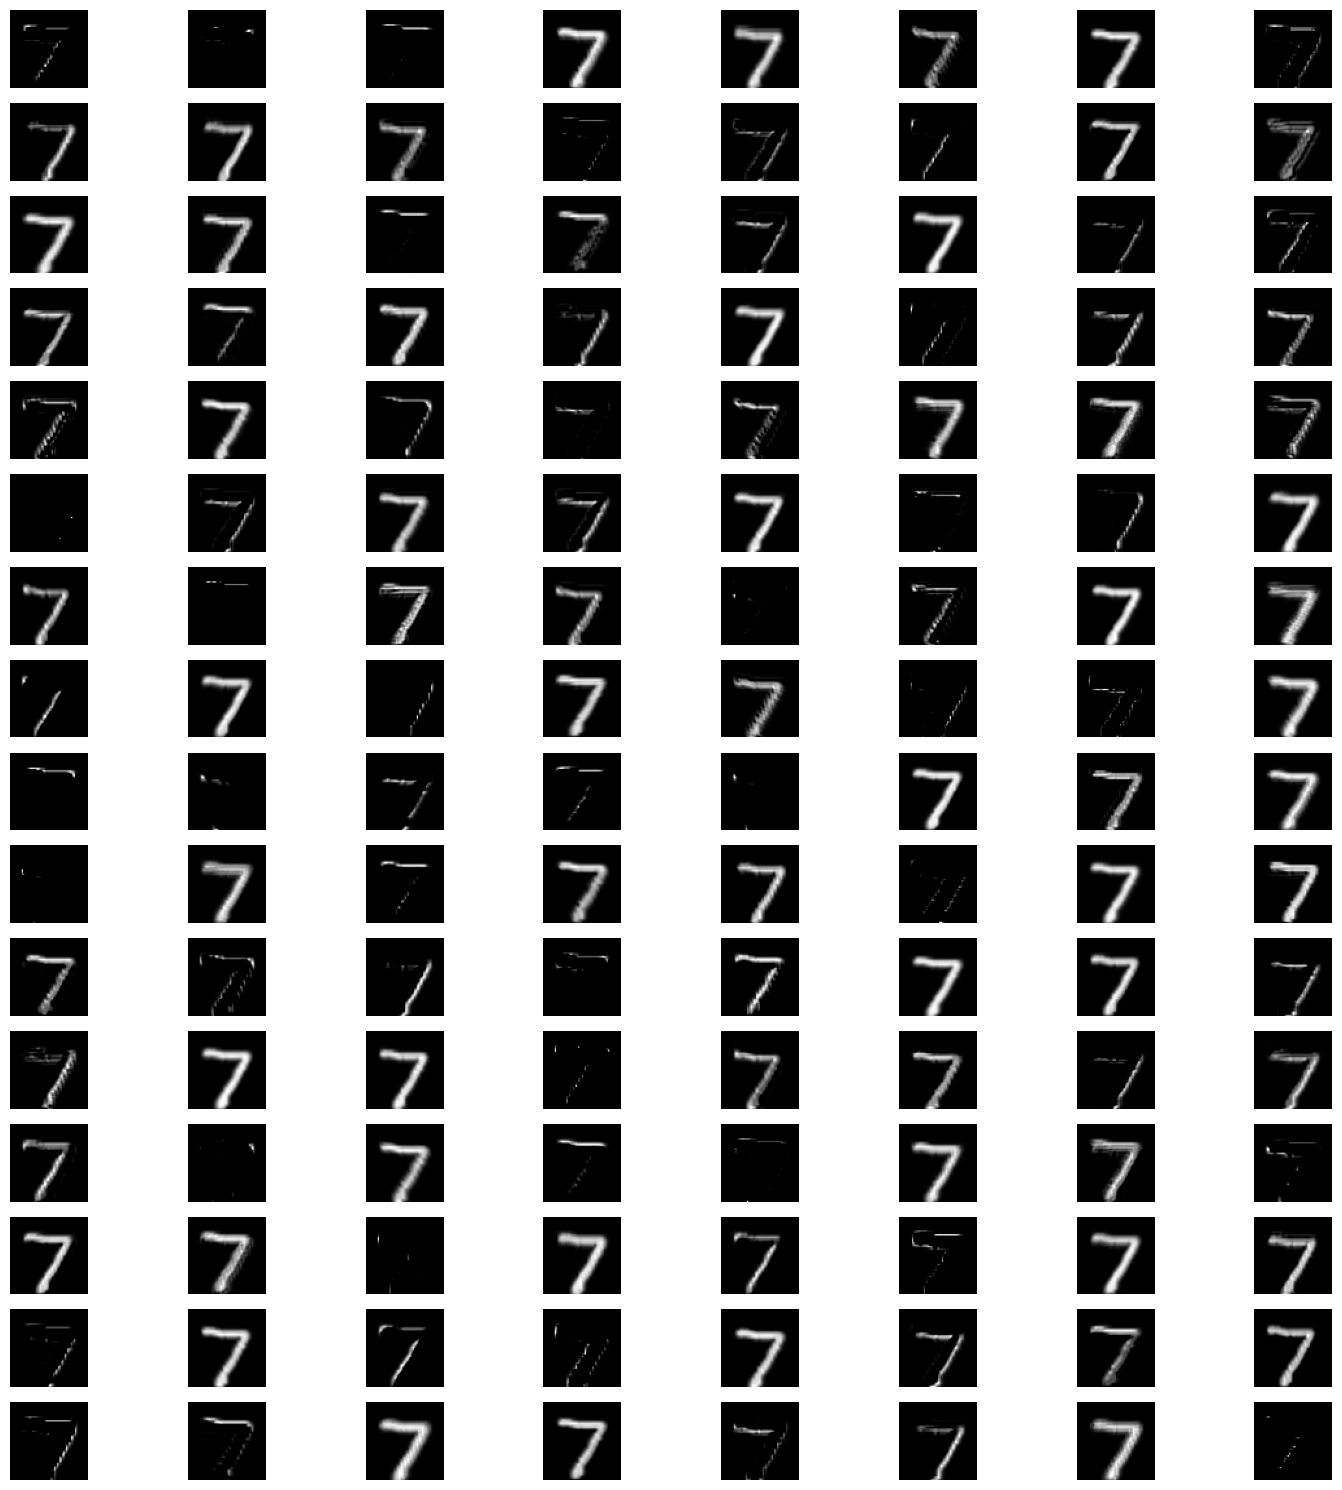

Layer 8: max_pooling2d_2 - Shape: (1, 30, 30, 128)


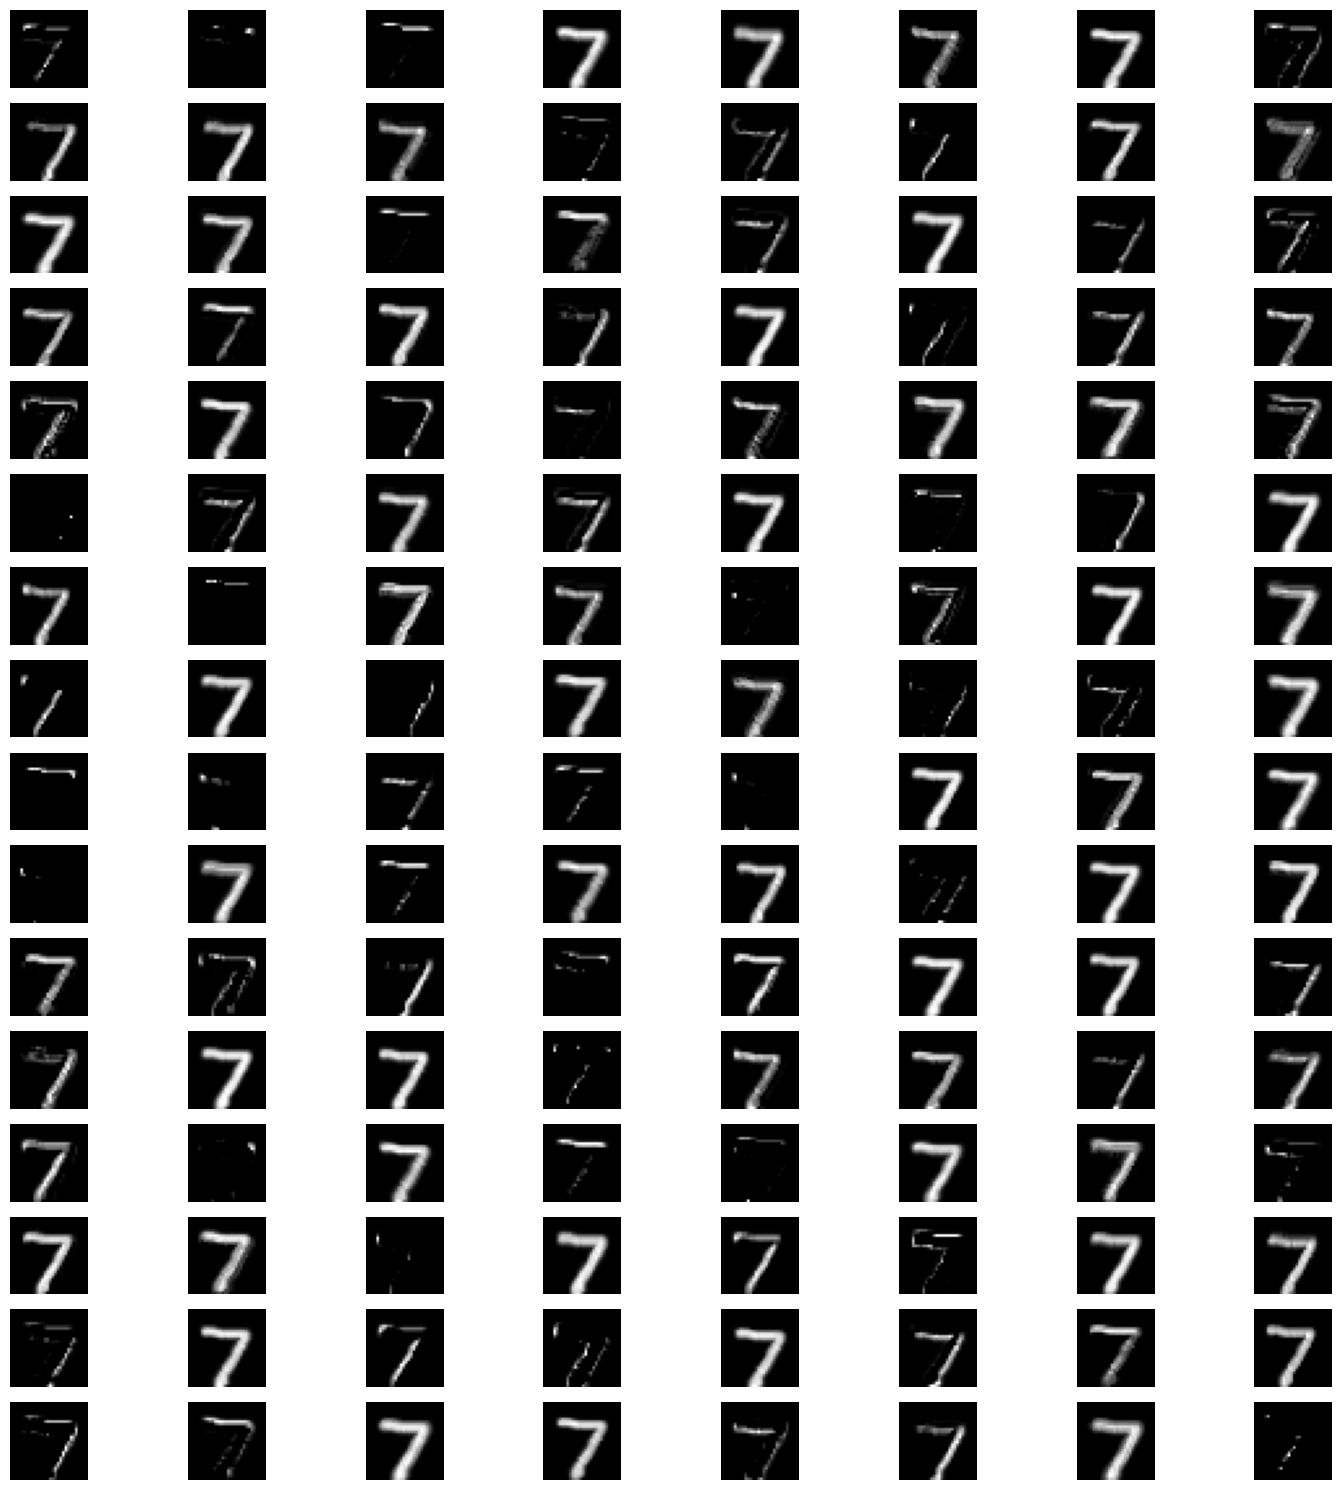

Layer 9: global_average_pooling2d - Shape: (1, 128)


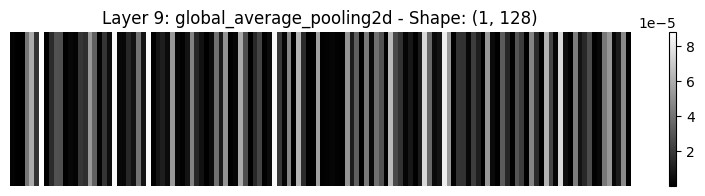

Layer 10: dense - Shape: (1, 128)


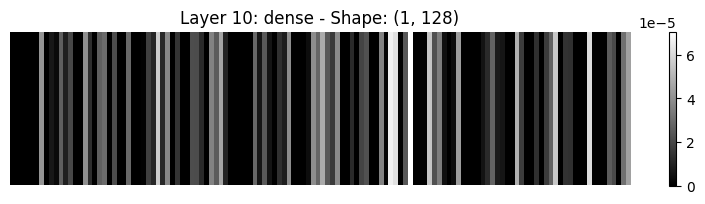

Layer 11: dropout - Shape: (1, 128)


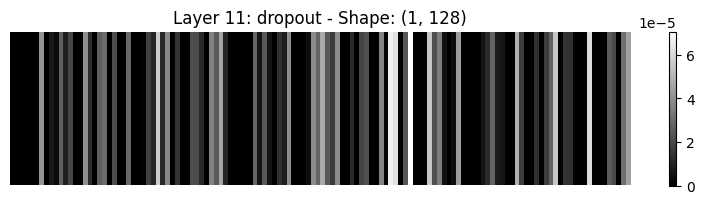

Layer 12: dense_1 - Shape: (1, 10)


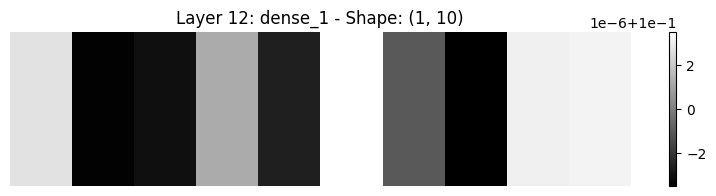

In [19]:
# Call the function with the MNIST image
visualize_model_layers(model, img_resized)

RESNET

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets

In [7]:
x_train = x_train[..., None] / 255.0  # Add channel dimension and normalize
x_test = x_test[..., None] / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [8]:
# Residual Block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # Add shortcut connection
    if stride != 1:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [9]:
# Build the simple ResNet model
def build_resnet(input_shape=(28, 28, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = residual_block(x, 32)
    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 128, stride=2)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

In [10]:
model = build_resnet()

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 28, 28, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 28, 28, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 28, 28, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 28, 28, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 28, 28, 32)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 28, 28, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 14, 14, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 14, 14, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 14, 14, 64)     │          2,112 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 14, 14, 64)     │              0 │ batch_normalization_4… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 14, 14, 64)     │              0 │ add_1[0][0]            │
├──────────────────────

 Total params: 309,322 (1.18 MB)

 Trainable params: 308,362 (1.18 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.8947 - loss: 0.3714 - val_accuracy: 0.9669 - val_loss: 0.1028
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9862 - loss: 0.0469 - val_accuracy: 0.9223 - val_loss: 0.2608
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9908 - loss: 0.0307 - val_accuracy: 0.9791 - val_loss: 0.0785
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9919 - loss: 0.0265 - val_accuracy: 0.9892 - val_loss: 0.0343
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9931 - loss: 0.0204 - val_accuracy: 0.9850 - val_loss: 0.0522
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9943 - loss: 0.0177 - val_accuracy: 0.9884 - val_loss: 0.0356
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9958 - loss: 0.0141 - val_accuracy: 0.9911 - val_loss: 0.0282
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9955 - loss: 0.0129 - va

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

313/313 - 1s - 5ms/step - accuracy: 0.9912 - loss: 0.0278
Test accuracy: 0.99


VGG16

In [20]:
from keras import layers, models

model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8311 - loss: 0.5182 - val_accuracy: 0.9837 - val_loss: 0.0539
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9774 - loss: 0.0814 - val_accuracy: 0.9888 - val_loss: 0.0381
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9856 - loss: 0.0527 - val_accuracy: 0.9892 - val_loss: 0.0362
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9878 - loss: 0.0404 - val_accuracy: 0.9908 - val_loss: 0.0345
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9890 - loss: 0.0369 - val_accuracy: 0.9919 - val_loss: 0.0349
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9906 - loss: 0.0304 - val_accuracy: 0.9904 - val_loss: 0.0349
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9929 - loss: 0.0217 - val_accuracy: 0.9910 - val_loss: 0.0321
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9931 - loss: 0.0222 - val_accuracy: 0.

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9894 - loss: 0.0369
Test accuracy: 0.9925000071525574
